In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

In [3]:
indian_names = open('./archive/names_indian.txt','r').read().splitlines()
us_names = open('./archive/names_western.txt','r').read().splitlines()
indian_names = [t.lower() for t in indian_names]
in_names = [name for name in indian_names if " " not in name]
in_names = [name for name in in_names if "-" not in name]
ix = np.random.randint(0,len(in_names),size=10)
print(len(in_names), len(us_names))
print([in_names[i] for i in ix],us_names[:10])

54785 32033
['virendar', 'sharajun', 'aparijita', 'nilavalaki', 'ishaan', 'shobhin', 'veenand', 'sarukasan', 'pavalan', 'samrat'] ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
print(in_names[ np.argmin([len(w) for w in in_names]) ] , us_names[ np.argmin([len(w) for w in us_names]) ] )
print(in_names[ np.argmax([len(w) for w in in_names]) ] , us_names[ np.argmax([len(w) for w in us_names]) ] )

an an
parthadhwajagrasamvasine muhammadibrahim


In [5]:
ltrs = sorted(set(''.join(us_names)))
ch_idx = {s:i+1 for i,s in enumerate(ltrs)}
ch_idx['.'] = 0
idx_ch = {i:s for s,i in ch_idx.items()}
print(ch_idx, idx_ch)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
context_length = 8
def make_data(names):
    X,y = [],[]
    for w in names:
        context = [0]*context_length
        for c in w + '.':
            X.append(context)
            y.append(ch_idx[c])
            context = context[1:] + [ch_idx[c]]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X,y
n1= int(0.8*len(us_names))
n2=int(0.9*len(us_names))
random.seed(42)
random.shuffle(us_names)
Xtr,ytr = make_data(us_names[:n1])      ; print(Xtr.shape, ytr.shape)
Xval, yval = make_data(us_names[n1:n2]) ; print(Xval.shape, yval.shape)
Xtest, ytest = make_data(us_names[n2:]) ; print(Xtest.shape, ytest.shape)

Xtr_in, ytr_in = make_data(in_names)    ; print(Xtr_in.shape, ytr_in.shape)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
torch.Size([494660, 8]) torch.Size([494660])


In [7]:
for x,y in zip(Xtr[:20],ytr[:20]):
    print(''.join( idx_ch[ix.item()] for ix in x ) , '--->' , idx_ch[y.item()] )

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [43]:
hidden_dim = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,5), generator =g)     # a feature vector to give the letters more data for the network to learn form not just single integers
W1 = torch.randn((context_length*C.shape[1] , hidden_dim) , generator =g)
b1 = torch.randn((hidden_dim, ), generator=g)
W2 = torch.randn((hidden_dim, 27), generator =g)
b2 = torch.randn((27, ), generator =g)
parameters = [C,W1,b1,W2,b2]

In [44]:
print(sum(p.nelement( ) for p in parameters))
for p in parameters:
    p.requires_grad = True

6962


In [45]:
def train(Xtr,ytr,loops=10000, lr = 1e-2, batch_size = 40, print_every = 100):
    step ,loss_histroy=[],[]
    for i in range(loops):
        ix = torch.randint(0,Xtr.shape[0],size=(batch_size,))
        x_input = Xtr[ix]
        y_input = ytr[ix]
        # features
        x_features = C[x_input]
        assert x_features.shape == (*x_input.shape,C.shape[1])
        # affine + relu
        out = torch.relu(x_features.view(len(ix), -1) @ W1 + b1)
        # scores
        scores = out @ W2 + b2

        loss = F.cross_entropy(scores,y_input )

        for p in parameters:
            p.grad = None
        
        loss.backward()
        with torch.no_grad():
            for p in parameters:
                p += -lr*p.grad
        if i%print_every ==0:
            print(loss.item())
        step.append(i); loss_histroy.append(loss.item())
    return step, loss_histroy


In [47]:
step, loss_his = train(Xtr,ytr,loops=800,batch_size =100,print_every=100)

2.694453716278076
2.8104124069213867
2.5727317333221436
2.8685338497161865
2.5914881229400635
2.4823594093322754
2.925907850265503
2.776839256286621


In [48]:
def forward(X ,y):
    # features
    x_features = C[X]
    assert x_features.shape == (*X.shape,C.shape[1])
    # affine + relu
    out = torch.relu(x_features.view(-1,context_length*C.shape[1]) @ W1 + b1)
    # scores
    scores = out @ W2 + b2

    loss = F.cross_entropy(scores,y)
    return loss

In [49]:
forward(Xval, yval).item()

2.6509511470794678

In [50]:
# word generator:
def word_generator(n=20):
    g = torch.Generator().manual_seed(2147483647 + 10)
    for _ in range(n):
        word=[]
        input = [0]*context_length
        while(True):
            
            out1 = torch.relu(C[input].view(1,-1) @ W1 + b1)
            scores = out1 @ W2 + b2
            probs = torch.softmax(scores, dim=1)
            ix = torch.multinomial(probs,num_samples=1, generator=g).item()
            input = input[1:] + [ix]
            word.append(ix)
            if ix == 0:
                break
        print(''.join([idx_ch[w] for w in word]))
word_generator(10)

eriaaimyay.
reelmn.
hryal.
retmrs.
ejdrlen.
adeeedie.
iileli.
jealeie.
seananar.
eltzioh.


In [14]:
from typing import Any

class Linear:
    def __init__(self,inp_dim, out_dim, bias = True) -> None:
        self.w = torch.randn((inp_dim, out_dim))/inp_dim**0.5
        self.bias = bias
        self.b = torch.zeros((out_dim,)) if self.bias else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.bias:
            self.out += self.b 
        return self.out
    
    def parameters(self):
        return [self.w] + ( [self.b] if self.bias else [] )
# ------------------------------------------------------------------------------  
class TANH:
    def __call__(self, x) -> Any:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
# ------------------------------------------------------------------------------
class Batchnorm:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps; self.momentum = momentum; self.training = True
        self.gamma = torch.ones(dim) ; self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim); self.running_var = torch.ones(dim)
    def __call__(self, x) -> Any:
        if self.training:
            xmean = torch.mean(x, dim= 0, keepdim=True) ; xvar = torch.var(x, dim=0, keepdim=True) #batchwise mean.
        else: 
            xmean = self.running_mean ; xvar = self.running_var
        self.out = self.gamma * (x-xmean)/torch.sqrt(xvar + self.eps)  + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * xmean + self.momentum
                self.running_var = (1- self.momentum) * xvar + self.momentum

        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
# ------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
# ------------------------------------------------------------------------------
class Embedding:
    def __init__(self, n=10) -> None:
        self.n = n
        self.C = torch.randn((27,n))
    def __call__(self,x):
        self.out = self.C[x]
        return self.out
    def parameters(self):
        return [self.C]
class Flatten:
    def __init__(self, batch_size):
        self.out_dim = batch_size
    def __call__(self,x):
        self.out = x.view(self.out_dim, -1)
        return self.out
    def parameters(self):
        return []

In [16]:
batch_size = 100
hid_dim = 100

In [17]:
# NL = [
#     Linear(context_length*C.shape[1], hid_dim) , TANH(),  #context_length is 4; in the first cell.
#     Linear(                  hid_dim, hid_dim) , TANH(),
#     Linear(                  hid_dim, hid_dim) , TANH(),
#     Linear(                       hid_dim, 27) ,
# ]
# parameters = [C] + [p for layer in NL for p in layer.parameters()]

# for p in parameters:
#     p.requires_grad = True

In [21]:
model = Sequential([ 
    Embedding(15), Flatten(batch_size),
    Linear(context_length*15, hid_dim, bias=False) , Batchnorm(hid_dim), TANH(),  #context_length is 4; in the first cell.
    Linear(                  hid_dim, hid_dim, bias=False) , Batchnorm(hid_dim), TANH(),
    Linear(                  hid_dim, hid_dim, bias=False) , Batchnorm(hid_dim), TANH(),
    Linear(                       hid_dim, 27, bias=False)
])
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
with torch.no_grad():
    model.layers[-1].w *= 0.1

In [24]:
upds = [] # std value ratios of updates/ p 
lossi = []
def train(Xtr, ytr, loops =10000, lr = 1e-2,batch_size = 100, print_every = 500):
    for i in range(loops):
        ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
        X = Xtr[ix] ; y = ytr[ix]
        # forward
        out = model(X)
        loss = F.cross_entropy(out, y)
        assert out.shape == (hid_dim,27)
        # making the parameters have no grads:
        for p in parameters:
            p.grad = None
        for layer in model.layers:
            layer.out.retain_grad()
        # backward
        loss.backward()
        #update the params
        with torch.no_grad():
            for p in parameters:
                p += -lr*p.grad
            upds.append( [((-lr*p.grad).std()/p.std()).log10().item() for p in parameters])
        #printing the loss
        if i%print_every ==1:
            print('iteration %d/ %d , losss: %.3f'%(i,loops, loss))
        lossi.append(loss.log10().item())
train(Xtr,ytr, print_every=500)

iteration 1/ 10000 , losss: 2.366


iteration 501/ 10000 , losss: 2.264
iteration 1001/ 10000 , losss: 2.354
iteration 1501/ 10000 , losss: 2.389
iteration 2001/ 10000 , losss: 2.104
iteration 2501/ 10000 , losss: 2.247
iteration 3001/ 10000 , losss: 2.287
iteration 3501/ 10000 , losss: 2.044
iteration 4001/ 10000 , losss: 2.123
iteration 4501/ 10000 , losss: 2.161
iteration 5001/ 10000 , losss: 2.142
iteration 5501/ 10000 , losss: 2.027
iteration 6001/ 10000 , losss: 1.999
iteration 6501/ 10000 , losss: 2.308
iteration 7001/ 10000 , losss: 2.072
iteration 7501/ 10000 , losss: 2.278
iteration 8001/ 10000 , losss: 2.396
iteration 8501/ 10000 , losss: 2.071
iteration 9001/ 10000 , losss: 2.190
iteration 9501/ 10000 , losss: 2.041


layer 2,__call__ : mean = -0.015 std = 0.632 saturated = 3.400%
layer 5,__call__ : mean = -0.007 std = 0.632 saturated = 4.190%
layer 8,__call__ : mean = -0.001 std = 0.634 saturated = 3.440%


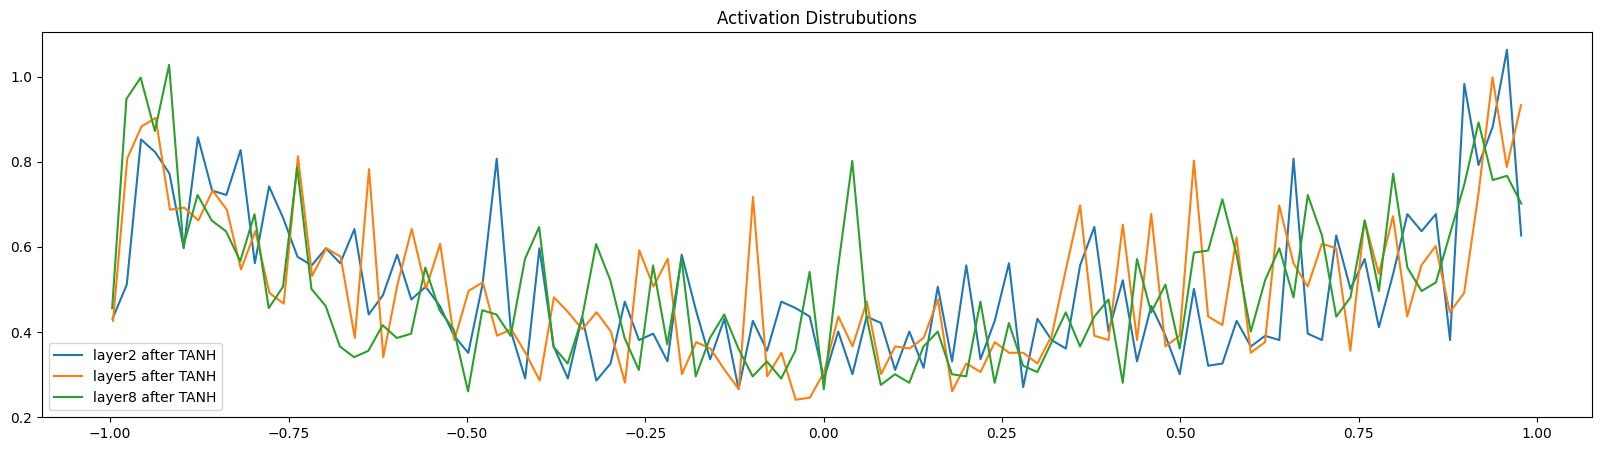

In [36]:
plt.figure(figsize=(20,5))
legend = []
for i,layer in enumerate(model[:-1]):
    if isinstance(layer, TANH):
        legend.append(f'layer{i} after {layer.__class__.__name__}')
        t = layer.out
        assert layer.out.grad is not None; 'Bro, somethin happen to the grads check it out'
        print('layer %d,%s : mean = %.3f std = %.3f saturated = %.3f%%'%(i,layer.__call__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach() ,hy.detach())
plt.legend(legend);
plt.title('Activation Distrubutions');

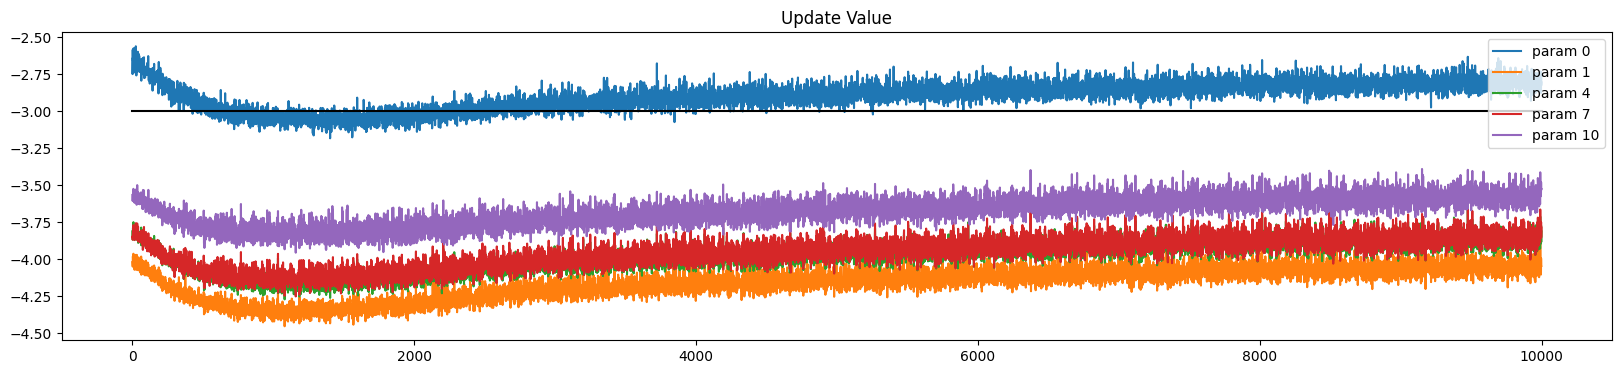

In [37]:
plt.figure(figsize=(20,4))
legends =[]
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([upds[l][i] for l in range(len(upds)) ] )
        legends.append(f'param {i}')
plt.plot([0,len(upds)], [-3,-3], 'k')
plt.legend(legends);
plt.title("Update Value");

layer 2 (      TANH): mean -0.000002, std 1.942875e-03
layer 5 (      TANH): mean -0.000004, std 1.935027e-03
layer 8 (      TANH): mean -0.000036, std 1.973218e-03


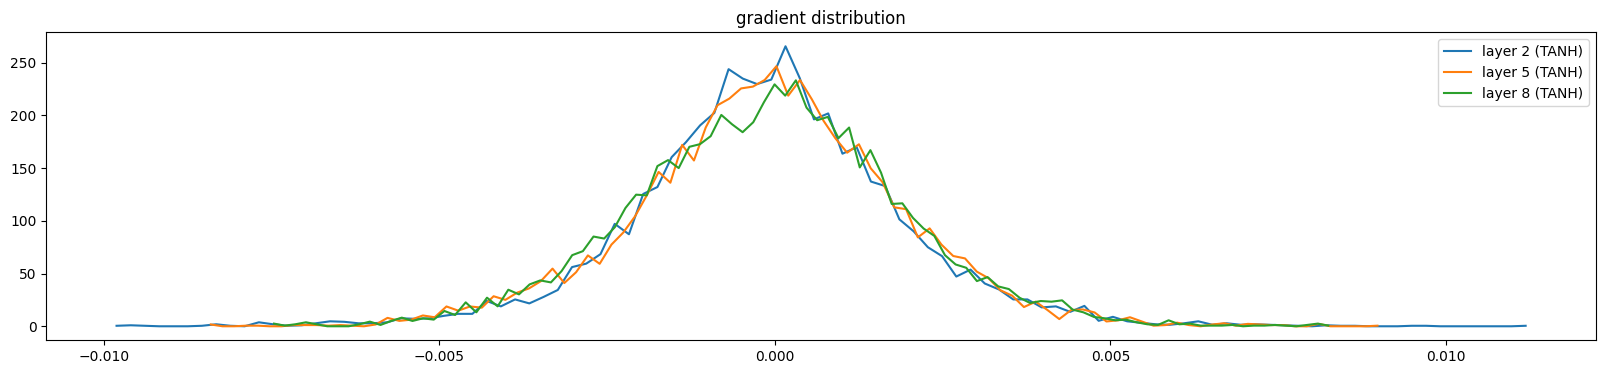

In [38]:
plt.figure(figsize=(20, 4))
legends = []
for i , layer in enumerate(NL[:-1]):
    if isinstance(layer, TANH):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000562 | std 3.124747e-02 | grad:data ratio 1.569019e-01
weight  (40, 100) | mean -0.000000 | std 4.338057e-03 | grad:data ratio 9.020818e-03
weight (100, 100) | mean +0.000000 | std 4.607684e-03 | grad:data ratio 1.544670e-02
weight (100, 100) | mean -0.000000 | std 4.922994e-03 | grad:data ratio 1.637472e-02
weight  (100, 27) | mean +0.000000 | std 9.004619e-03 | grad:data ratio 2.988482e-02


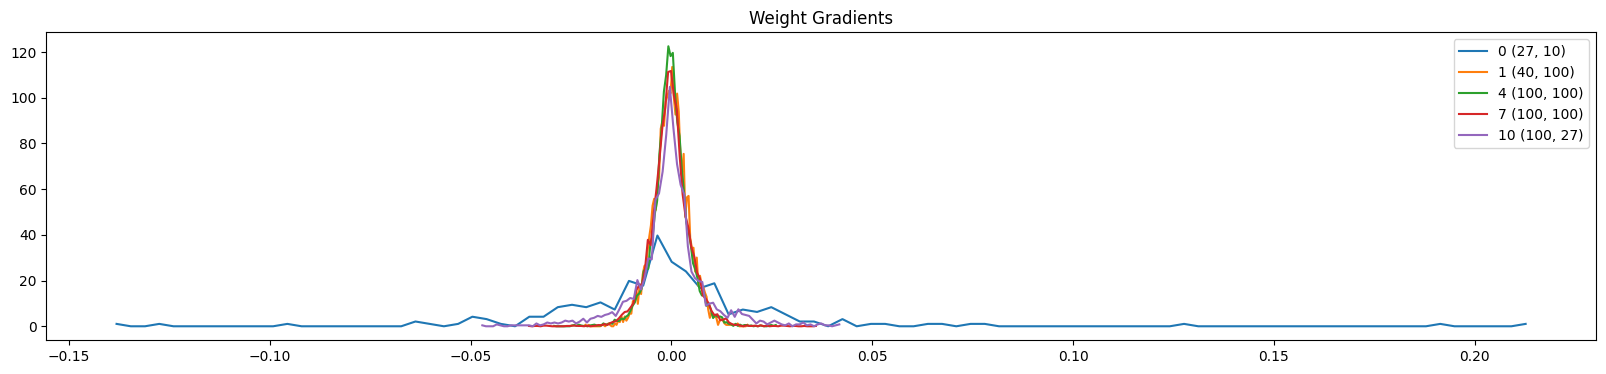

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim ==2:
        t = p.grad
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weight Gradients');

In [40]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in NL:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(idx_ch[i] for i in out)) # decode and print the generated word

mria.
kmyay.
seel.
ndhryal.
rethastendrlen.
azerydieliih.
miloel.
edeison.
anar.
kayzioh.
karin.
shdbergshirie.
tinnir.
jelionnter.
foub.
kyvdi.
kylyni.
ehgyn.
ajayannyan.
hilina.


In [ ]:
# trained a 10,000 times:
# mora.
# kmyan.
# seel.
# ndyn.
# alarethan.
# ejdrle.
# caderidieliah.
# miloelle.
# elisa.
# anar.
# kayzioh.
# kalin.
# shabergxhganes.
# kendreelle.
# jethana.
# uberynder.
# yahun.
# eha.
# kayshistouda.
# halina.

### trained a 100,000 times. montay.
yazziel.
madhayla.
reise.
jens.
legender.
daeliigh.
porell.
keisean.
naraelynn.
hones.
noshus.
ridhi.
jessin.
joselynn.
noella.
ububye.
ariyah.
faeh.
yuma.